In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [2]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sub = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

## EDA

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
numcols = df.describe().columns
numcols_without_id_target = numcols.drop(["Id", "SalePrice"])

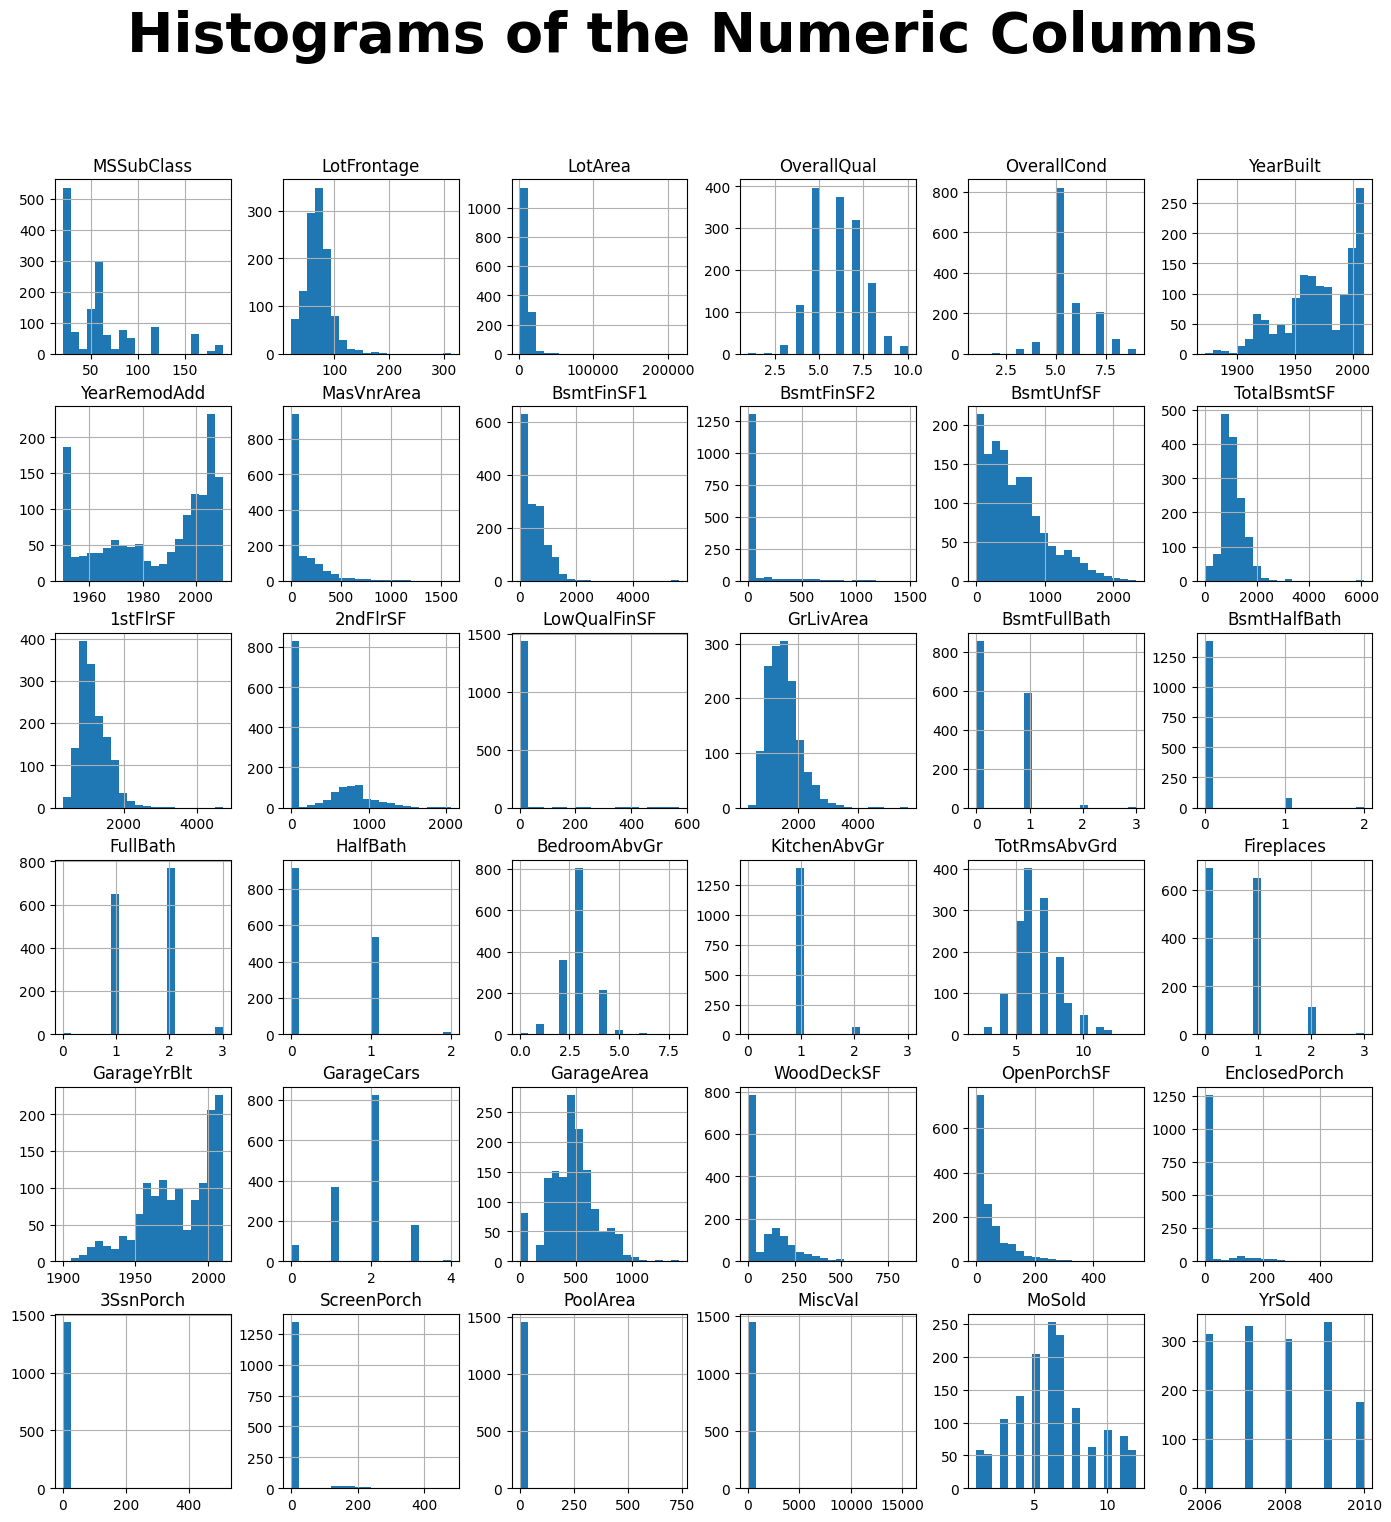

In [5]:
df[numcols_without_id_target].hist(bins = 20 ,figsize = (17, 17), linewidth=1.2)
plt.suptitle("Histograms of the Numeric Columns", fontsize=40, fontweight="bold")
plt.show()

In [6]:
skewness = df[numcols_without_id_target].skew()
high_skew_cols = skewness[skewness > 0.75].index
filtered_cols = [col for col in high_skew_cols if df[col].nunique() > 1]
print("Features selected:", filtered_cols)

Features selected: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


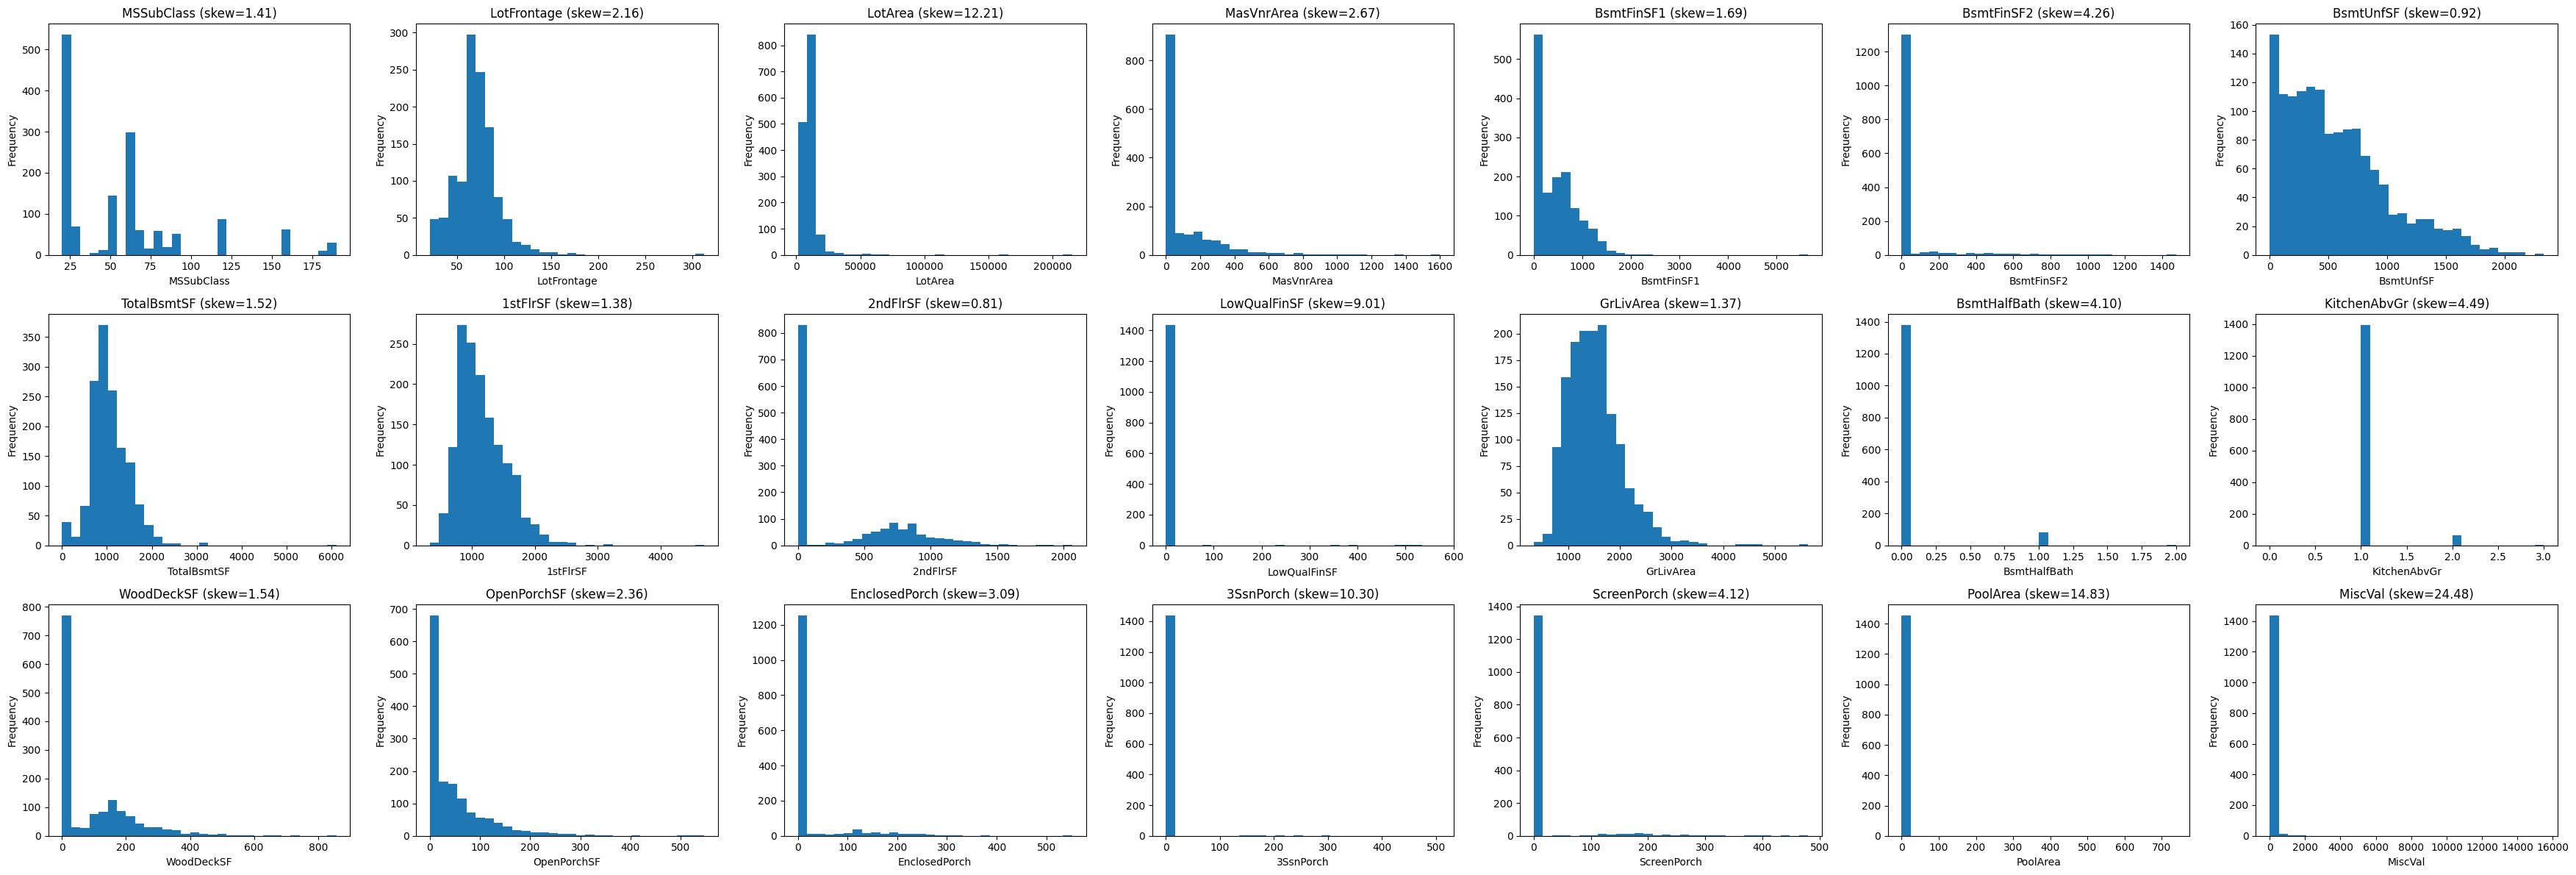

In [7]:
n_cols = 7
n_rows = (len(filtered_cols) + n_cols - 1) // n_cols

# Step 5 — plot all histograms in one single image
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(filtered_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"{col} (skew={skewness[col]:.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("high_skew_histograms.png", dpi=300)
plt.show()

In [8]:
df.isna().sum()[df.isna().sum() > 0]/len(df)*100

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

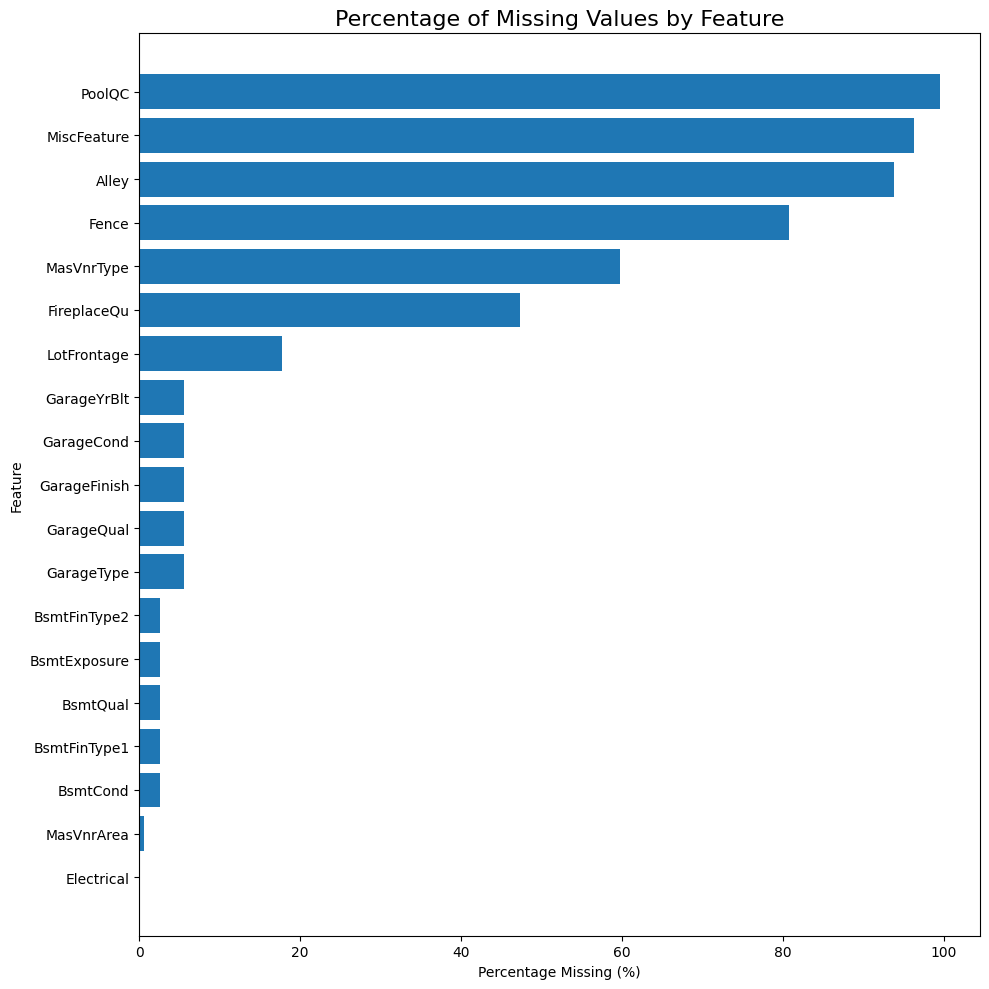

In [9]:
missing_percentage = (df.isna().sum() / len(df)) * 100

missing_percentage = missing_percentage[missing_percentage > 0]

if missing_percentage.empty:
    print("No missing values found in the DataFrame!")
else:
    missing_percentage_sorted = missing_percentage.sort_values(ascending=True)
    
    plt.figure(figsize=(10, 10)) 
    
    plt.barh(
        missing_percentage_sorted.index, 
        missing_percentage_sorted.values  
    )
    
    # Add titles and labels
    plt.title('Percentage of Missing Values by Feature', fontsize=16)
    plt.xlabel('Percentage Missing (%)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig("missing_values_counts.png", dpi=300)
    plt.show()

## Feature Engineering

In [10]:
# ⚙️ Import Transformer
from sklearn.preprocessing import FunctionTransformer

# 🗑️ Drop Columns
drop_cols = ["Id", "Alley", "PoolQC", "Fence", "MiscFeature"]


# ------------------------------
# 🏗️ Feature Engineering Function
# ------------------------------
def added_features(df):
    df_out = df.copy()

    # Drop high null columns
    df_out.drop(columns=drop_cols, errors="ignore")
    
    # Age
    df_out["PropertyAge"] = df_out["YrSold"] - df_out["YearBuilt"]

    # Area
    df_out["TotalSF"] = df_out["TotalBsmtSF"] + df_out["1stFlrSF"] + df_out["2ndFlrSF"]
    df_out["TotalBath"] = df_out["FullBath"] + 0.5 * df_out["HalfBath"] + df_out["BsmtFullBath"] + 0.5 * df_out["BsmtHalfBath"]

    # Remodeled? 
    df_out["HasRemodeled"] = (df_out["YearRemodAdd"] != df_out["YearBuilt"]).astype(object)

    # Binary features for property amenities
    df_out["HasPool"] = (df_out["PoolArea"] > 0).astype(int)
    df_out["HasBasement"] = (df_out["TotalBsmtSF"] > 0).astype(int)
    df_out["HasFireplace"] = (df_out["Fireplaces"] > 0).astype(int)
    df_out["Has2ndFloor"] = (df_out["2ndFlrSF"] > 0).astype(object)
    df_out["HasGarage"] = (df_out["GarageArea"] > 0).astype(object)

    # Convert some numeric features to categorical
    df_out["YrSold_cat"] = df_out["YrSold"].astype(object)
    df_out["MoSold_cat"] = df_out["MoSold"].astype(object)
    df_out["YearBuilt_cat"] = df_out["YearBuilt"].astype(object)
    df_out["MSSubClass_cat"] = df_out["MSSubClass"].astype(object)

    # Good Overall Quality
    df_out["OverallGrade"] = df_out["OverallQual"] * df_out["OverallCond"]
    df_out["QualityArea"] = df_out["OverallQual"] * df_out["GrLivArea"]
    
    
    return df_out

# ------------------------------
# 🔄 Wrap Feature Engineering into Transformer
# ------------------------------
feature_transformer = FunctionTransformer(added_features)

## Preprocessing Pipelines

In [11]:
new_cols_categorical = pd.Index(["HasRemodeled", "Has2ndFloor", "HasGarage",
                                 "YrSold_cat", "MoSold_cat", "YearBuilt_cat",
                                 "MSSubClass_cat"])
new_cols_numeric = pd.Index(["PropertyAge", "TotalSF", "TotalBath", 
                             "HasFireplace", "HasBasement", "HasPool",
                             "OverallGrade", "QualityArea"])


categorical_columns = df.select_dtypes(include=["object", "category"]).columns.append(new_cols_categorical)
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns.append(new_cols_numeric)


# 🎯 Drop Target Column from Numerics
numerical_columns = numerical_columns.drop("SalePrice")

In [12]:
# ⚙️ Import Sklearn Tools for Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 🗃️ Categorical Pipeline
cat_transform = Pipeline(steps = [
                                  ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
                                  ("onehot", OneHotEncoder(handle_unknown="ignore", sparse = False))
                                 ])

# 🔢 Numerical Pipeline
num_transform = Pipeline(steps = [
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaler", StandardScaler())
                                 ])

In [13]:
preprocessor = ColumnTransformer(transformers=[("cat", cat_transform, categorical_columns),
                                               ("num", num_transform, numerical_columns)
                                               ], 
                                                 remainder = "passthrough")

# ------------------------------
# 🏗️ Create Full Pipeline with Feature Engineering
# ------------------------------
pipeline = Pipeline(steps=[
    ("engineer", feature_transformer),
    ("preprocessor", preprocessor)])

# 📝 Apply Pipeline to Dataset
X = df.drop("SalePrice", axis=1)
y = np.log(df["SalePrice"]) #normalize dependent variable 

X_preprocessed = pipeline.fit_transform(X)

test_preprocessed = pipeline.transform(test)

In [14]:
# --- Add this code after you've run pipeline.fit_transform(X) ---

# 1. Get the preprocessor step from your main pipeline
preprocessor = pipeline.named_steps['preprocessor']

# 2. Get the OneHotEncoder step from the categorical transformer
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']

# 3. Get the list of original categorical and numerical column names
# (You already defined these, just re-using the variable names)
original_cat_cols = categorical_columns
original_num_cols = numerical_columns

# 4. Get the *new* feature names from the OneHotEncoder
new_cat_features = onehot_encoder.get_feature_names_out(original_cat_cols)

# 5. Combine the new categorical names and the original numerical names
# The ColumnTransformer stacks them in the order you defined ("cat", "num")
all_feature_names = list(new_cat_features) + list(original_num_cols)

# 6. Create the new, human-readable DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# --- Now you can visualize it ---
print("Transformed DataFrame head:")
print(X_preprocessed_df.head())

Transformed DataFrame head:
   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0               0.0          0.0          0.0          1.0          0.0   
1               0.0          0.0          0.0          1.0          0.0   
2               0.0          0.0          0.0          1.0          0.0   
3               0.0          0.0          0.0          1.0          0.0   
4               0.0          0.0          0.0          1.0          0.0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_None  Alley_Pave  ...  \
0          0.0          1.0         0.0         1.0         0.0  ...   
1          0.0          1.0         0.0         1.0         0.0  ...   
2          0.0          1.0         0.0         1.0         0.0  ...   
3          0.0          1.0         0.0         1.0         0.0  ...   
4          0.0          1.0         0.0         1.0         0.0  ...   

     MoSold    YrSold  PropertyAge   TotalSF  TotalBath  HasFireplace  \
0 -1.599111  0.

In [15]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import optuna

## Hyperparameter Tuning (Optuna)

In [16]:
# 🎯 Define Objectives for Optuna
objectives = {}

# ------------------------------
# 🌲 LightGBM Objective
# ------------------------------
def objective_lgbm(trial):
    params = {
        "n_estimators": 1000,
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "verbose": -1
    }
    model = LGBMRegressor(**params)
    score = -cross_val_score(model, X_preprocessed, y,
                             cv=5, scoring="neg_root_mean_squared_error").mean()
    return score
objectives["LightGBM"] = objective_lgbm


# ------------------------------
# 🏛️ Ridge Objective
# ------------------------------
def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
    model = Ridge(alpha=alpha, random_state=132)
    score = -cross_val_score(model, X_preprocessed, y,
                             cv=5, scoring="neg_root_mean_squared_error").mean()
    return score
objectives["Ridge"] = objective_ridge



# ------------------------------
# ⚡ ElasticNet Objective
# ------------------------------
def objective_elastic(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                       random_state=132, max_iter=20000)
    score = -cross_val_score(model, X_preprocessed, y,
                             cv=5, scoring="neg_root_mean_squared_error").mean()
    return score
objectives["ElasticNet"] = objective_elastic



# ------------------------------
# 🎢 Kernel Ridge Regression Objective
# ------------------------------
def objective_krr(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "polynomial", "rbf"])
    if kernel == "polynomial":
        degree = trial.suggest_int("degree", 2, 5)
        coef0 = trial.suggest_float("coef0", 0.0, 5.0)
        model = KernelRidge(alpha=alpha, kernel=kernel, degree=degree, coef0=coef0)
    else:
        model = KernelRidge(alpha=alpha, kernel=kernel)
    score = -cross_val_score(model, X_preprocessed, y,
                             cv=5, scoring="neg_root_mean_squared_error").mean()
    return score
objectives["KernelRidge"] = objective_krr



# ------------------------------
# 🐉 XGBoost Objective
# ------------------------------
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cuda",
        "random_state": 42,
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
    }
    model = XGBRegressor(**params)
    score = -cross_val_score(model, X_preprocessed, y,
                             cv=5, scoring="neg_root_mean_squared_error").mean()
    return score
objectives["XGBoost"] = objective_xgb

In [17]:
# ------------------------------
# 🏁 Run Optuna Hyperparameter Optimization
# ------------------------------
best_params = {}
best_scores = {}

for name, objective in objectives.items():
    print(f"\n🔎 Optimizing {name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5, show_progress_bar=True) 
    # Best params were found with 150 n_trials.
    
    best_params[name] = study.best_params
    best_scores[name] = study.best_value
    
    print(f"✅ {name} best RMSE: {study.best_value:.5f}")
    print(f"Best params: {study.best_params}")

[I 2025-11-17 15:07:32,015] A new study created in memory with name: no-name-86171e30-ea35-4172-8666-486fd5863667



🔎 Optimizing LightGBM...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-17 15:07:44,051] Trial 0 finished with value: 0.1287736973646155 and parameters: {'learning_rate': 0.05190130792992216, 'num_leaves': 293, 'max_depth': 0, 'subsample': 0.5898048494987718, 'colsample_bytree': 0.8706967980040264, 'reg_alpha': 0.00012074114153083718, 'reg_lambda': 1.198072082850822}. Best is trial 0 with value: 0.1287736973646155.
[I 2025-11-17 15:07:46,576] Trial 1 finished with value: 0.12678758036425752 and parameters: {'learning_rate': 0.0746980000771733, 'num_leaves': 186, 'max_depth': 4, 'subsample': 0.8854894465900844, 'colsample_bytree': 0.743652480052424, 'reg_alpha': 0.0011349884929872313, 'reg_lambda': 0.003783781551816722}. Best is trial 1 with value: 0.12678758036425752.
[I 2025-11-17 15:07:48,642] Trial 2 finished with value: 0.12455040597242055 and parameters: {'learning_rate': 0.025864678448687346, 'num_leaves': 234, 'max_depth': 3, 'subsample': 0.7844455605973941, 'colsample_bytree': 0.738321501627823, 'reg_alpha': 0.3337147939023339, 'reg_lamb

[I 2025-11-17 15:08:02,699] A new study created in memory with name: no-name-f0549396-126e-4cd3-8611-5ccaadf40bf4


[I 2025-11-17 15:08:02,695] Trial 4 finished with value: 0.12591913944668964 and parameters: {'learning_rate': 0.05991013859110455, 'num_leaves': 145, 'max_depth': 11, 'subsample': 0.9797611793586625, 'colsample_bytree': 0.5626676200456899, 'reg_alpha': 0.0002239403703309826, 'reg_lambda': 0.9325578540150911}. Best is trial 2 with value: 0.12455040597242055.
✅ LightGBM best RMSE: 0.12455
Best params: {'learning_rate': 0.025864678448687346, 'num_leaves': 234, 'max_depth': 3, 'subsample': 0.7844455605973941, 'colsample_bytree': 0.738321501627823, 'reg_alpha': 0.3337147939023339, 'reg_lambda': 0.6027930778594163}

🔎 Optimizing Ridge...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-17 15:08:03,048] Trial 0 finished with value: 0.13701743012046144 and parameters: {'alpha': 15.910828536637426}. Best is trial 0 with value: 0.13701743012046144.
[I 2025-11-17 15:08:03,201] Trial 1 finished with value: 0.1642488919495054 and parameters: {'alpha': 0.0011116749326447865}. Best is trial 0 with value: 0.13701743012046144.
[I 2025-11-17 15:08:03,337] Trial 2 finished with value: 0.1377779484071125 and parameters: {'alpha': 5.325535836913231}. Best is trial 0 with value: 0.13701743012046144.
[I 2025-11-17 15:08:03,534] Trial 3 finished with value: 0.15431207138593553 and parameters: {'alpha': 0.19160787024981651}. Best is trial 0 with value: 0.13701743012046144.


[I 2025-11-17 15:08:03,687] A new study created in memory with name: no-name-0851a9b2-d450-4f77-891a-538fd7b90fff


[I 2025-11-17 15:08:03,685] Trial 4 finished with value: 0.16032922880055986 and parameters: {'alpha': 0.044265076411097184}. Best is trial 0 with value: 0.13701743012046144.
✅ Ridge best RMSE: 0.13702
Best params: {'alpha': 15.910828536637426}

🔎 Optimizing ElasticNet...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-17 15:08:05,112] Trial 0 finished with value: 0.13440516421588491 and parameters: {'alpha': 0.0004809291578563042, 'l1_ratio': 0.6688009393929577}. Best is trial 0 with value: 0.13440516421588491.
[I 2025-11-17 15:08:05,359] Trial 1 finished with value: 0.1535909667256552 and parameters: {'alpha': 0.062242683281732096, 'l1_ratio': 0.11907359631363543}. Best is trial 0 with value: 0.13440516421588491.
[I 2025-11-17 15:08:05,460] Trial 2 finished with value: 0.3992282792085989 and parameters: {'alpha': 0.8629851766577401, 'l1_ratio': 0.81939847346808}. Best is trial 0 with value: 0.13440516421588491.
[I 2025-11-17 15:08:05,711] Trial 3 finished with value: 0.15894509045082933 and parameters: {'alpha': 0.016642577548011704, 'l1_ratio': 0.9409430671968677}. Best is trial 0 with value: 0.13440516421588491.


[I 2025-11-17 15:08:06,016] A new study created in memory with name: no-name-a0f6cac9-8140-4041-888b-79686da8d6f8


[I 2025-11-17 15:08:06,014] Trial 4 finished with value: 0.14909143665161642 and parameters: {'alpha': 0.004315850567167623, 'l1_ratio': 0.8335939807415733}. Best is trial 0 with value: 0.13440516421588491.
✅ ElasticNet best RMSE: 0.13441
Best params: {'alpha': 0.0004809291578563042, 'l1_ratio': 0.6688009393929577}

🔎 Optimizing KernelRidge...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-17 15:08:06,558] Trial 0 finished with value: 0.1337707253142148 and parameters: {'alpha': 0.0491378159542993, 'kernel': 'polynomial', 'degree': 4, 'coef0': 1.975200270512674}. Best is trial 0 with value: 0.1337707253142148.
[I 2025-11-17 15:08:07,161] Trial 1 finished with value: 0.6086182553090363 and parameters: {'alpha': 1.7197290945715709, 'kernel': 'rbf'}. Best is trial 0 with value: 0.1337707253142148.
[I 2025-11-17 15:08:07,708] Trial 2 finished with value: 0.30298615829267855 and parameters: {'alpha': 0.03874149434853641, 'kernel': 'polynomial', 'degree': 5, 'coef0': 0.3502377825141584}. Best is trial 0 with value: 0.1337707253142148.
[I 2025-11-17 15:08:08,305] Trial 3 finished with value: 0.7106411530049266 and parameters: {'alpha': 3.778116437990153, 'kernel': 'rbf'}. Best is trial 0 with value: 0.1337707253142148.


[I 2025-11-17 15:08:08,797] A new study created in memory with name: no-name-0ea54661-d4f1-4b1d-acd5-43ef748c591b


[I 2025-11-17 15:08:08,792] Trial 4 finished with value: 0.7956380109708493 and parameters: {'alpha': 6.915574006067892, 'kernel': 'rbf'}. Best is trial 0 with value: 0.1337707253142148.
✅ KernelRidge best RMSE: 0.13377
Best params: {'alpha': 0.0491378159542993, 'kernel': 'polynomial', 'degree': 4, 'coef0': 1.975200270512674}

🔎 Optimizing XGBoost...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-17 15:08:14,280] Trial 0 finished with value: 0.12102721536785481 and parameters: {'max_depth': 3, 'learning_rate': 0.010061589158094335, 'subsample': 0.8180487229456233, 'colsample_bytree': 0.7108077919794762, 'reg_alpha': 0.30561340686028843, 'reg_lambda': 0.04510648472666612}. Best is trial 0 with value: 0.12102721536785481.
[I 2025-11-17 15:08:26,728] Trial 1 finished with value: 0.2078772526329975 and parameters: {'max_depth': 10, 'learning_rate': 0.002013072432906481, 'subsample': 0.506730195635858, 'colsample_bytree': 0.8669793818437226, 'reg_alpha': 8.10751682562393, 'reg_lambda': 0.570045013274996}. Best is trial 0 with value: 0.12102721536785481.
[I 2025-11-17 15:08:40,990] Trial 2 finished with value: 0.13785583539818475 and parameters: {'max_depth': 7, 'learning_rate': 0.003845273207839066, 'subsample': 0.6286609047296939, 'colsample_bytree': 0.6431918588345763, 'reg_alpha': 0.2512721959045734, 'reg_lambda': 8.763050893356958}. Best is trial 0 with value: 0.12102

In [18]:
# ------------------------------
# 🏆 Best Hyperparameters from Optuna Optimization
# -----------------------------
# These parameters were found to be the best after 150 trials
best_params_dict = {
    "Ridge": {'alpha': 6.577845021836757}, 
    
    "ElasticNet": {'alpha': 0.001175898057027851, 
                   'l1_ratio': 0.2556675520546301},
    
    "KernelRidge": {'alpha': 0.1476316691169565, 
                    'kernel': 'polynomial', 
                    'degree': 2, 
                    'coef0': 2.082659943772578},
    
    "XGBoost": {'max_depth': 4, 
                'learning_rate': 0.02373014388999918,
                'subsample': 0.8423921813587263, 
                'colsample_bytree': 0.5228354076316597,
                'reg_alpha': 0.00014172841523401867, 
                'reg_lambda': 0.008005196902006313},
    
    "LightGBM": {'learning_rate': 0.06234817414958063, 
                 'num_leaves': 278, 
                 'max_depth': 2, 
                 'subsample': 0.593312100941863, 
                 'colsample_bytree': 0.7497991100268827, 
                 'reg_alpha': 0.0001354219967120134, 
                 'reg_lambda': 5.097599798916927, 
                 'verbose': -1}
}

## Train Tuned Base Models

In [19]:
# ------------------------------
# 🤖 Initialize Tuned Models with Best Hyperparameters
# ------------------------------
tuned_models = [
    ("Ridge", Ridge(**best_params_dict["Ridge"], random_state=132)),
    ("ElasticNet", ElasticNet(**best_params_dict["ElasticNet"], random_state=132, max_iter=20000)),
    ("KernelRidge", KernelRidge(**best_params_dict["KernelRidge"])),
    ("XGBoost", XGBRegressor(**best_params_dict["XGBoost"], random_state=132)),
    ("LightGBM", LGBMRegressor(**best_params_dict["LightGBM"], random_state=132))
]

In [20]:
# ------------------------------
# 🔄 Out-of-Fold (OOF) Cross-Validation
# ------------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
oof_preds = {name: np.zeros(len(X)) for name, _ in tuned_models}


# ------------------------------
# 🏋️ Train Tuned Models with K-Fold CV
# ------------------------------
for name, model in tuned_models:
    print(f"Training tuned model: {name}")
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_preprocessed, y), 1):
        X_tr, X_val = X_preprocessed[tr_idx], X_preprocessed[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        oof_preds[name][val_idx] = preds
        
    # ------------------------------
    # 📏 Evaluate each Model with RMSE
    # ------------------------------
    rmse = np.sqrt(mean_squared_error(y, oof_preds[name]))
    print(f"{name} OOF RMSE: {rmse:.5f}")

Training tuned model: Ridge
Ridge OOF RMSE: 0.13882
Training tuned model: ElasticNet
ElasticNet OOF RMSE: 0.13821
Training tuned model: KernelRidge
KernelRidge OOF RMSE: 0.12227
Training tuned model: XGBoost
XGBoost OOF RMSE: 0.14286
Training tuned model: LightGBM
LightGBM OOF RMSE: 0.13824


## Stacking / Meta-Model

In [21]:
# ------------------------------
# 🔗 Create Out-of-Fold (OOF) Features for Stacking
# ------------------------------
X_meta = pd.DataFrame(oof_preds)

# ------------------------------
# 🎯 Define Objective for Meta-Model (ElasticNet)
# ------------------------------
def objective_meta(trial):
    # Suggest hyperparameters
    alpha = trial.suggest_float("alpha", 1e-5, 1.0, log=True)    # smaller range can help fine-tune regularization
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)    # balance between L1 and L2

    
    # Define meta model
    meta_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=20000)
    
    # Cross-validation on OOF preds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    preds = np.zeros_like(y, dtype=float)
    
    for tr_idx, val_idx in kf.split(X_meta):
        X_tr, X_val = X_meta.iloc[tr_idx], X_meta.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        meta_model.fit(X_tr, y_tr)
        preds[val_idx] = meta_model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y, preds))
    return score

# ------------------------------
# 🏁 Run Optuna Optimization for Meta-Model
# ------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective_meta, n_trials=150, show_progress_bar=True)

[I 2025-11-17 15:09:05,016] A new study created in memory with name: no-name-2d5b1b45-74ef-4679-b52e-73125761ba18


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-17 15:09:05,050] Trial 0 finished with value: 0.12190405160430469 and parameters: {'alpha': 7.019364364888865e-05, 'l1_ratio': 0.5457932934939911}. Best is trial 0 with value: 0.12190405160430469.
[I 2025-11-17 15:09:05,069] Trial 1 finished with value: 0.1237982795640896 and parameters: {'alpha': 0.005291223010700761, 'l1_ratio': 0.8213642005081236}. Best is trial 0 with value: 0.12190405160430469.
[I 2025-11-17 15:09:05,086] Trial 2 finished with value: 0.273607948611547 and parameters: {'alpha': 0.1179856889469193, 'l1_ratio': 0.7489836345895844}. Best is trial 0 with value: 0.12190405160430469.
[I 2025-11-17 15:09:05,105] Trial 3 finished with value: 0.12206692593182857 and parameters: {'alpha': 0.00027229453835378426, 'l1_ratio': 0.5489432578314831}. Best is trial 0 with value: 0.12190405160430469.
[I 2025-11-17 15:09:05,124] Trial 4 finished with value: 0.12263326993296961 and parameters: {'alpha': 0.003165326644754019, 'l1_ratio': 0.8858172257864547}. Best is trial 0 

In [22]:
# ------------------------------
# 📊 Display Best Meta-Model Results
# ------------------------------
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

Best RMSE: 0.12164189415838658
Best params: {'alpha': 1.015106037544986e-05, 'l1_ratio': 0.0001588365038600281}


In [23]:
# ------------------------------
# 🏗️ Train Final Meta-Model with Best Hyperparameters
# ------------------------------
best_meta = ElasticNet(**study.best_params, random_state=42, max_iter=20000)
best_meta.fit(X_meta, y)


# ------------------------------
# 📏 Evaluate Stacked Meta-Model on Training Data
# ------------------------------
meta_pred = best_meta.predict(X_meta)
meta_rmse = np.sqrt(mean_squared_error(y, meta_pred))
print(f"Final Meta-model RMSE: {meta_rmse:.5f}")

Final Meta-model RMSE: 0.11818


## Final Prediction & Submission

In [24]:
# 🔄 Generate Test Set Predictions for Base Models
test_meta = pd.DataFrame({name: model.predict(test_preprocessed) for name, model in tuned_models})


# 🏗️ Predict with Stacked Meta-Model
stack_pred = best_meta.predict(test_meta)
final_pred = np.expm1(stack_pred) # Reverse log-transform


# ------------------------------
# 💾 Prepare Kaggle Submission File
# ------------------------------
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": final_pred
})
submission.to_csv("submission.csv", index=False)

print("✅ Successfully created submission file!")
print("="*50)
print("First 5 rows of the submission file:")
submission.head()

✅ Successfully created submission file!
First 5 rows of the submission file:


,Id,SalePrice
0,1461,118105.357740
1,1462,159505.899655
2,1463,176527.803134
3,1464,195043.511771
4,1465,193022.204316
